# Testing the Efficacy of Airbnb's 90 Day Limit on Entire Home Listings

**Research Question:** Did the imposition of the 90 day limit reduce the growth rate in proportion of entire home listings over 90 days in comparison to single rooms?

**H0:** there is no difference in the change in proportion of entire home listings exceeding 90 days compared to single room listings after the imposition of the 90-day limit.

**HA:** there is a difference in the change in proportion of entire home listings exceeding 90 days compared to single room listings after the imposition of the 90-day limit.

The policy was introduced in Jan 2017, so I will test for differences in proportions between 2016 and 2017. There is, however, a possibility of a time lag, which means different years may yield different results.

As this notebook aims to be reproducible and we are getting close to submission time, I'm not going to keep record of any QAing/data exploration - I'll only keep things which I think might make it into the final document.

In [1]:
#Loading packages
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt 
import os
import datetime as dt
import seaborn as sns
import duckdb as db
import statsmodels.api as sm
from requests import get
from urllib.parse import urlparse
from functools import wraps
from scipy.stats import chi2_contingency
from scipy.stats import ttest_rel
import statsmodels.formula.api as smf
print(os.getcwd())

/home/jovyan/work/CASA0013 - Foundations of Spatial Data Science/New Repo/CASA0013_FSDS_Airbnb-data-analytics/Documentation


## 1. Data Processing

### 1.1 Review Data

In [2]:
#Our Github has run out of storage so we cannot upload the data here
#Instead I will use Jon's code to download the June 2024 reviews from his website and save it locally

url  = 'https://orca.casa.ucl.ac.uk/~jreades/data/20240614-London-reviews.csv.gz'

def check_cache(f):
    @wraps(f)
    def wrapper(src, dst, min_size=100):
        url = urlparse(src) # We assume that this is some kind of valid URL 
        fn  = os.path.split(url.path)[-1] # Extract the filename
        dsn = os.path.join(dst,fn) # Destination filename
        if os.path.isfile(dsn) and os.path.getsize(dsn) > min_size:
            print(f"+ {dsn} found locally!")
            return(dsn)
        else:
            print(f"+ {dsn} not found, downloading!")
            return(f(src, dsn))
    return wrapper

@check_cache
def cache_data(src:str, dst:str) -> str:
    """Downloads a remote file.
    
    The function sits between the 'read' step of a pandas or geopandas
    data frame and downloading the file from a remote location. The idea
    is that it will save it locally so that you don't need to remember to
    do so yourself. Subsequent re-reads of the file will return instantly
    rather than downloading the entire file for a second or n-th itme.
    
    Parameters
    ----------
    src : str
        The remote *source* for the file, any valid URL should work.
    dst : str
        The *destination* location to save the downloaded file.
        
    Returns
    -------
    str
        A string representing the local location of the file.
    """

    # Convert the path back into a list (without)
    # the filename -- we need to check that directories
    # exist first.
    path = os.path.split(dst)[0]
    print(f"Path: {path}")
      
    # Create any missing directories in dest(ination) path
    # -- os.path.join is the reverse of split (as you saw above)
    # but it doesn't work with lists... so I had to google how
    # to use the 'splat' operator! os.makedirs creates missing
    # directories in a path automatically.
    if path != '':
        os.makedirs(path, exist_ok=True)
        
    # Download and write the file
    with open(dst, "wb") as file:
        response = get(src)
        file.write(response.content)
        
    print(' + Done downloading...')

    return dst

ddir = os.path.join('Documentation','data', 'raw') # destination directory
path  = cache_data(url, ddir)
reviews = pd.read_csv(path, compression='gzip')

+ Documentation/data/raw/20240614-London-reviews.csv.gz found locally!


In [3]:
reviews.head() #Loaded successfully

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,13913,80770,2010-08-18,177109,Michael,My girlfriend and I hadn't known Alina before ...
1,13913,367568,2011-07-11,19835707,Mathias,Alina was a really good host. The flat is clea...
2,13913,529579,2011-09-13,1110304,Kristin,Alina is an amazing host. She made me feel rig...
3,13913,595481,2011-10-03,1216358,Camilla,"Alina's place is so nice, the room is big and ..."
4,13913,612947,2011-10-09,490840,Jorik,"Nice location in Islington area, good for shor..."


In [4]:
#Changing date data type
reviews["date"] = pd.to_datetime(reviews["date"], format="%Y-%m-%d")

In [5]:
#Filtering to 2015-2018
reviews['year'] = reviews.date.dt.year
reviews = reviews[(reviews.year > 2014) & (reviews.year < 2019)]

In [6]:
#Dropping unnecessary columns
reviews.drop(columns = ["id", "date", "reviewer_name", "reviewer_id", "comments"], inplace=True)

### 1.2 Listing Data

In [7]:
listings = pd.read_csv("data/raw/listings.csv.gz")
listings.head() #Loaded successfully

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,13913,https://www.airbnb.com/rooms/13913,20240906025501,2024-09-06,city scrape,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,...,4.84,4.72,4.72,NaN,f,3,2,1,0,0.26
1,15400,https://www.airbnb.com/rooms/15400,20240906025501,2024-09-07,city scrape,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,It is Chelsea.,https://a0.muscache.com/pictures/428392/462d26...,60302,...,4.84,4.93,4.75,NaN,f,1,1,0,0,0.54
2,17402,https://www.airbnb.com/rooms/17402,20240906025501,2024-09-07,city scrape,Fab 3-Bed/2 Bath & Wifi: Trendy W1,"You'll have a great time in this beautiful, cl...","Fitzrovia is a very desirable trendy, arty and...",https://a0.muscache.com/pictures/39d5309d-fba7...,67564,...,4.72,4.89,4.61,NaN,f,6,6,0,0,0.34
3,24328,https://www.airbnb.com/rooms/24328,20240906025501,2024-09-07,city scrape,"Battersea live/work artist house, garden & par...","Artist house, bright high ceiling rooms for bo...","- Battersea is a quiet family area, easy acces...",https://a0.muscache.com/pictures/9194b40f-c627...,41759,...,4.93,4.59,4.65,NaN,f,1,1,0,0,0.56
4,33332,https://www.airbnb.com/rooms/33332,20240906025501,2024-09-06,city scrape,Beautiful Ensuite Richmond-upon-Thames borough,"Walking distance to Twickenham Stadium, 35 min...",Peaceful and friendly.,https://a0.muscache.com/pictures/miso/Hosting-...,144444,...,4.50,4.67,4.22,NaN,f,2,0,2,0,0.11


In [8]:
listings = listings[["id", "host_id", "room_type", "minimum_nights"]]

In [9]:
listings.head()

,id,host_id,room_type,minimum_nights
0,13913,54730,Private room,1
1,15400,60302,Entire home/apt,4
2,17402,67564,Entire home/apt,3
3,24328,41759,Entire home/apt,2
4,33332,144444,Private room,2


### 1.3 Join Tables and Calculate Occupancy Metric

Using Wang et al. (2024) occupancy estimation:
1. Count reviews per listing per year
2. Divide by 0.5 (assume that 1 in 2 stays results in a review)
3. Join to the listings dataset
4. Estimate stay length: either 3 days or minimum nights, whichever is larger
5. Multiply this by review rate
6. Cap at 21 nights per month (252) - *although technically 2016 was a leap year*

Finally, work out whether a listing had estimated over 90 nights or not

In [10]:
#Step 1: count reviews per listing per year
reviews_annual = reviews.groupby(['listing_id', 'year']).size().unstack(fill_value=0)
years = range(2015, 2019)
#Rename columns
year_columns = {year: f'reviews_{year}' for year in years}
reviews_annual.rename(columns=year_columns, inplace=True)
reviews_annual = reviews_annual.reset_index()
reviews_annual.columns.name = None

reviews_annual.head()

,listing_id,reviews_2015,reviews_2016,reviews_2017,reviews_2018
0,13913,1,1,1,2
1,15400,12,15,7,3
2,17402,4,0,0,14
3,24328,32,12,0,0
4,33332,0,0,0,2


In [11]:
#Step 2: divide each year by 0.5 (assume that 1 in 2 stays results in a review)
for year in years:
    reviews_annual[f'reviews_{year}_adjusted'] = reviews_annual[f'reviews_{year}'] / 0.5

reviews_annual.head()

,listing_id,reviews_2015,reviews_2016,reviews_2017,reviews_2018,reviews_2015_adjusted,reviews_2016_adjusted,reviews_2017_adjusted,reviews_2018_adjusted
0,13913,1,1,1,2,2.0,2.0,2.0,4.0
1,15400,12,15,7,3,24.0,30.0,14.0,6.0
2,17402,4,0,0,14,8.0,0.0,0.0,28.0
3,24328,32,12,0,0,64.0,24.0,0.0,0.0
4,33332,0,0,0,2,0.0,0.0,0.0,4.0


In [12]:
#Step 3: join to the listings dataset

reviews_annual = reviews_annual.merge(listings, how='left', left_on='listing_id', right_on='id').drop(columns=['id'])

In [13]:
#Checking for nulls
cols_to_check = ["host_id", "room_type", "minimum_nights"]

for col in cols_to_check:
    if reviews_annual[col].isna().sum() == 0:
        print(f'{col}: No nulls')
    else:
        print(f'{col}: Contains nulls')

host_id: Contains nulls
room_type: Contains nulls
minimum_nights: Contains nulls


In [14]:
reviews_annual.info()

#18152/19027 joined correctly - 95% present
#A limitation (and potential bias), but not a lot we can do!

#I could look at 2016 file if time, but this might not include 2017/2018 data

reviews_annual.dropna(subset=['room_type'], inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19027 entries, 0 to 19026
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   listing_id             19027 non-null  int64  
 1   reviews_2015           19027 non-null  int64  
 2   reviews_2016           19027 non-null  int64  
 3   reviews_2017           19027 non-null  int64  
 4   reviews_2018           19027 non-null  int64  
 5   reviews_2015_adjusted  19027 non-null  float64
 6   reviews_2016_adjusted  19027 non-null  float64
 7   reviews_2017_adjusted  19027 non-null  float64
 8   reviews_2018_adjusted  19027 non-null  float64
 9   host_id                18152 non-null  float64
 10  room_type              18152 non-null  object 
 11  minimum_nights         18152 non-null  float64
dtypes: float64(6), int64(5), object(1)
memory usage: 1.7+ MB


In [15]:
reviews_annual.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18152 entries, 0 to 19026
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   listing_id             18152 non-null  int64  
 1   reviews_2015           18152 non-null  int64  
 2   reviews_2016           18152 non-null  int64  
 3   reviews_2017           18152 non-null  int64  
 4   reviews_2018           18152 non-null  int64  
 5   reviews_2015_adjusted  18152 non-null  float64
 6   reviews_2016_adjusted  18152 non-null  float64
 7   reviews_2017_adjusted  18152 non-null  float64
 8   reviews_2018_adjusted  18152 non-null  float64
 9   host_id                18152 non-null  float64
 10  room_type              18152 non-null  object 
 11  minimum_nights         18152 non-null  float64
dtypes: float64(6), int64(5), object(1)
memory usage: 1.8+ MB


In [16]:
#Step 4: calculating estimated nights column: greater of either 3 or minimum nights
reviews_annual['estimated_stay'] = np.maximum(3, reviews_annual.minimum_nights)

reviews_annual.head()

,listing_id,reviews_2015,reviews_2016,reviews_2017,reviews_2018,reviews_2015_adjusted,reviews_2016_adjusted,reviews_2017_adjusted,reviews_2018_adjusted,host_id,room_type,minimum_nights,estimated_stay
0,13913,1,1,1,2,2.0,2.0,2.0,4.0,54730.0,Private room,1.0,3.0
1,15400,12,15,7,3,24.0,30.0,14.0,6.0,60302.0,Entire home/apt,4.0,4.0
2,17402,4,0,0,14,8.0,0.0,0.0,28.0,67564.0,Entire home/apt,3.0,3.0
3,24328,32,12,0,0,64.0,24.0,0.0,0.0,41759.0,Entire home/apt,2.0,3.0
4,33332,0,0,0,2,0.0,0.0,0.0,4.0,144444.0,Private room,2.0,3.0


In [17]:
#Step 5: estimate occupied nights for each year by multiplying the adjusted review rate by the estimated stay duration
#n.b. this assumes that the minimum nights has not changed over time
#Step 6: cap at 21 days per month (not changing 2016 leap year as 1/365 = 0.002...)

cap_nights = 12 * 21  # max 21 days per month
for year in years:
    reviews_annual[f'estimated_nights{year}'] = reviews_annual[f'reviews_{year}_adjusted'] * reviews_annual.estimated_stay
    reviews_annual[f'estimated_nights{year}_capped'] = np.minimum(cap_nights, reviews_annual[f'estimated_nights{year}'])

reviews_annual.head()

,listing_id,reviews_2015,reviews_2016,reviews_2017,reviews_2018,reviews_2015_adjusted,reviews_2016_adjusted,reviews_2017_adjusted,reviews_2018_adjusted,host_id,...,minimum_nights,estimated_stay,estimated_nights2015,estimated_nights2015_capped,estimated_nights2016,estimated_nights2016_capped,estimated_nights2017,estimated_nights2017_capped,estimated_nights2018,estimated_nights2018_capped
0,13913,1,1,1,2,2.0,2.0,2.0,4.0,54730.0,...,1.0,3.0,6.0,6.0,6.0,6.0,6.0,6.0,12.0,12.0
1,15400,12,15,7,3,24.0,30.0,14.0,6.0,60302.0,...,4.0,4.0,96.0,96.0,120.0,120.0,56.0,56.0,24.0,24.0
2,17402,4,0,0,14,8.0,0.0,0.0,28.0,67564.0,...,3.0,3.0,24.0,24.0,0.0,0.0,0.0,0.0,84.0,84.0
3,24328,32,12,0,0,64.0,24.0,0.0,0.0,41759.0,...,2.0,3.0,192.0,192.0,72.0,72.0,0.0,0.0,0.0,0.0
4,33332,0,0,0,2,0.0,0.0,0.0,4.0,144444.0,...,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,12.0


In [18]:
#Calculating final table: whether a listing had True or False for over 90 days, and aggregated by room type
#Only looking at room type for now connected to research question, but I have the host column in there to check for superhosts if necessary

#Getting number of over 90s and totals for each category, as this is what the statistical test requires

#ChatGPT suggested taking a dynamic approach which integrates the year variable into the query and iterate over it
#But this felt a bit dishonest as it's not something I would have written myself
#So please excuse the slightly unwiedly query - it's not the most scalable but it is legible and it was written entirely by me!

db.register('reviews_annual', reviews_annual)

query = '''
       WITH listings_90 AS (
            SELECT 
            listing_id,
            CASE WHEN room_type = 'Entire home/apt' THEN 'Entire Home' ELSE 'Other' END AS room_type,
            CASE WHEN estimated_nights2015_capped >= 90 THEN 1 ELSE 0 END AS over90_2015,
            CASE WHEN estimated_nights2015_capped BETWEEN 1 AND 90 THEN 1 ELSE 0 END AS under90_2015,
            CASE WHEN estimated_nights2016_capped >= 90 THEN 1 ELSE 0 END AS over90_2016,
            CASE WHEN estimated_nights2016_capped BETWEEN 1 AND 90 THEN 1 ELSE 0 END AS under90_2016,
            CASE WHEN estimated_nights2017_capped >= 90 THEN 1 ELSE 0 END AS over90_2017,
            CASE WHEN estimated_nights2017_capped BETWEEN 1 AND 90 THEN 1 ELSE 0 END AS under90_2017,
            CASE WHEN estimated_nights2018_capped >= 90 THEN 1 ELSE 0 END AS over90_2018,
            CASE WHEN estimated_nights2018_capped BETWEEN 1 AND 90 THEN 1 ELSE 0 END AS under90_2018
        FROM reviews_annual)
    SELECT
        room_type,
        SUM(over90_2015) AS over90_2015,
        SUM(over90_2015) + SUM(under90_2015) AS total_2015,
        SUM(over90_2016) AS over90_2016,
        SUM(over90_2016) + SUM(under90_2016) AS total_2016,
        SUM(over90_2017) AS over90_2017,
        SUM(over90_2017)+SUM(under90_2017) AS total_2017,
        SUM(over90_2018) AS over90_2018,
        SUM(over90_2018)+SUM(under90_2018) AS total_2018
    FROM listings_90
    GROUP BY 1
'''

proportions_room = db.sql(query).to_df()
proportions_room.head()

,room_type,over90_2015,total_2015,over90_2016,total_2016,over90_2017,total_2017,over90_2018,total_2018
0,Entire Home,615.0,2312.0,1132.0,3937.0,1539.0,5893.0,2019.0,7522.0
1,Other,524.0,1746.0,908.0,2950.0,1444.0,4341.0,2037.0,5525.0


In [19]:
#Calculating final table: whether a listing had True or False for over 90 days, and aggregated by host type
#The below calculation is not ideal as a host might have become a Superhost later

#Getting number of over 90s and totals for each category, as this is what the statistical test requires

query2 = '''
       WITH host_type AS (
       SELECT 
           host_id,
           CASE WHEN COUNT(*)>1 THEN 'Multi-Listing Host' ELSE 'Single Property Host' END AS host_type           
       FROM reviews_annual
       GROUP BY 1),
       
       listings_90 AS (
            SELECT 
            r.listing_id,
            h.host_type,
            CASE WHEN r.estimated_nights2015_capped >= 90 THEN 1 ELSE 0 END AS over90_2015,
            CASE WHEN r.estimated_nights2015_capped BETWEEN 1 AND 90 THEN 1 ELSE 0 END AS under90_2015,
            CASE WHEN r.estimated_nights2016_capped >= 90 THEN 1 ELSE 0 END AS over90_2016,
            CASE WHEN r.estimated_nights2016_capped BETWEEN 1 AND 90 THEN 1 ELSE 0 END AS under90_2016,
            CASE WHEN r.estimated_nights2017_capped >= 90 THEN 1 ELSE 0 END AS over90_2017,
            CASE WHEN r.estimated_nights2017_capped BETWEEN 1 AND 90 THEN 1 ELSE 0 END AS under90_2017,
            CASE WHEN r.estimated_nights2018_capped >= 90 THEN 1 ELSE 0 END AS over90_2018,
            CASE WHEN r.estimated_nights2018_capped BETWEEN 1 AND 90 THEN 1 ELSE 0 END AS under90_2018
        FROM reviews_annual r
            LEFT JOIN host_type h
                ON r.host_id=h.host_id)
        
    SELECT
        host_type,
        SUM(over90_2015) AS over90_2015,
        SUM(over90_2015) + SUM(under90_2015) AS total_2015,
        SUM(over90_2016) AS over90_2016,
        SUM(over90_2016) + SUM(under90_2016) AS total_2016,
        SUM(over90_2017) AS over90_2017,
        SUM(over90_2017)+SUM(under90_2017) AS total_2017,
        SUM(over90_2018) AS over90_2018,
        SUM(over90_2018)+SUM(under90_2018) AS total_2018
    FROM listings_90
    GROUP BY 1
'''

proportions_host = db.sql(query2).to_df()
proportions_host.head()

,host_type,over90_2015,total_2015,over90_2016,total_2016,over90_2017,total_2017,over90_2018,total_2018
0,Single Property Host,683.0,2913.0,1226.0,4910.0,1710.0,6793.0,2344.0,8395.0
1,Multi-Listing Host,456.0,1145.0,814.0,1977.0,1273.0,3441.0,1712.0,4652.0


## 2. Statistical Tests

### 2.1. Room Type Change

In [20]:
#Brief proportions
db.register('proportions_room', proportions_room)

query3 = '''
        SELECT room_type,
               ROUND(100 * over90_2015/total_2015, 2) AS pct_90_2015,
               ROUND(100 * over90_2016/total_2016, 2) AS pct_90_2016,
               ROUND(100 * over90_2017/total_2017, 2) AS pct_90_2017,
               ROUND(100 * over90_2018/total_2018, 2) AS pct_90_2018
        FROM proportions_room
        '''
room_proportions = db.sql(query3).to_df()
room_proportions.head()

,room_type,pct_90_2015,pct_90_2016,pct_90_2017,pct_90_2018
0,Entire Home,26.60,28.75,26.12,26.84
1,Other,30.01,30.78,33.26,36.87


In [21]:
#Conducting a two proportion z-test for proportions of property types above and below 90 days in 2016 and 2017
#Room type is independent and sample size is over 10 for each category
#https://www.statsmodels.org/dev/generated/statsmodels.stats.proportion.proportions_ztest.html

#H0: there is no difference in the proportion of properties estimated over 90 days for each room type.
#H1: there is a difference in the proportion of properties estimated over 90 days for each room type.

#Entire Home z-test
count_eh = [proportions_room[proportions_room.room_type=='Entire Home'].over90_2016,
               proportions_room[proportions_room.room_type=='Entire Home'].over90_2017]
nobs_eh = [proportions_room[proportions_room.room_type=='Entire Home'].total_2016,
              proportions_room[proportions_room.room_type=='Entire Home'].total_2017]

z_eh, p_eh = sm.stats.proportions_ztest(count_eh, nobs_eh)

#Other z-test
count_other = [proportions_room[proportions_room.room_type=='Other'].over90_2016,
               proportions_room[proportions_room.room_type=='Other'].over90_2017]
nobs_other = [proportions_room[proportions_room.room_type=='Other'].total_2016,
              proportions_room[proportions_room.room_type=='Other'].total_2017]

z_other, p_other = sm.stats.proportions_ztest(count_other, nobs_other)

print(f"Z-statistic for 'Other' room type: {z_other}, P-value: {p_other}")
print(f"Z-statistic for 'Entire Home' room type: {z_eh}, P-value: {p_eh}")

#Reject H0 for both
# Entire Home decrease is statistically significant at the 95% level
# Other increase is statistically significant at the 99% level

Z-statistic for 'Other' room type: [-2.2274678], P-value: [0.02591603]
Z-statistic for 'Entire Home' room type: [2.88002066], P-value: [0.00397649]


### 2.2 Superhost Change

n.b. Problems with the data joining mean we may not have an accurate representation of which hosts were superhosts and which weren't, as approx. 5% of listings weren't able to be joined

In [22]:
#Brief proportions
db.register('proportions_host', proportions_host)

query4 = '''
        SELECT host_type,
               ROUND(100 * over90_2015/total_2015, 2) AS pct_90_2015,
               ROUND(100 * over90_2016/total_2016, 2) AS pct_90_2016,
               ROUND(100 * over90_2017/total_2017, 2) AS pct_90_2017,
               ROUND(100 * over90_2018/total_2018, 2) AS pct_90_2018
        FROM proportions_host
        '''
host_proportions = db.sql(query4).to_df()
host_proportions.head()

,host_type,pct_90_2015,pct_90_2016,pct_90_2017,pct_90_2018
0,Single Property Host,23.45,24.97,25.17,27.92
1,Multi-Listing Host,39.83,41.17,37.00,36.80


In [23]:
#H0: there is no difference in the proportion of properties estimated over 90 days for each host type.
#H1: there is a difference in the proportion of properties estimated over 90 days for each host type.

#Superhost z-test
count_m = [proportions_host[proportions_host.host_type=='Multi-Listing Host'].over90_2016,
               proportions_host[proportions_host.host_type=='Multi-Listing Host'].over90_2017]
nobs_m = [proportions_host[proportions_host.host_type=='Multi-Listing Host'].total_2016,
              proportions_host[proportions_host.host_type=='Multi-Listing Host'].total_2017]

z_m, p_m = sm.stats.proportions_ztest(count_m, nobs_m)

#Single property host z-test
count_s = [proportions_host[proportions_host.host_type=='Single Property Host'].over90_2016,
               proportions_host[proportions_host.host_type=='Single Property Host'].over90_2017]
nobs_s = [proportions_host[proportions_host.host_type=='Single Property Host'].total_2016,
              proportions_host[proportions_host.host_type=='Single Property Host'].total_2017]

z_s, p_s = sm.stats.proportions_ztest(count_s, nobs_s)

print(f"Z-statistic for Multi-Listing Hosts: {z_m}, P-value: {p_m}")
print(f"Z-statistic for Single Property Hosts: {z_s}, P-value: {p_s}")

# Multi-listing host decrease is statistically significant at the 99% level - reject H0
# Single property host had no statistically significant change - accept H0

Z-statistic for Multi-Listing Hosts: [3.04249831], P-value: [0.00234623]
Z-statistic for Single Property Hosts: [-0.25062717], P-value: [0.80210237]


### 2.3 Host Type Change

In [25]:
#Getting data
proportions_host_change = proportions_host[["host_type", "total_2015", "total_2016", "total_2017", "total_2018"]].copy()
proportions_host_change

,host_type,total_2015,total_2016,total_2017,total_2018
0,Single Property Host,2913.0,4910.0,6793.0,8395.0
1,Multi-Listing Host,1145.0,1977.0,3441.0,4652.0


In [26]:
#Two proportion z-test: is there a significant change?

#H0: there is no statistically significant difference in proportion of multiple listing hosts between 2016 and 2017
#H1: there is a statistically significant difference in proportion of multiple listing host between 2016 and 2017

count_t = [proportions_host_change.total_2016[0], proportions_host_change.total_2017[0]]
nobs_t = [sum(proportions_host_change["total_2016"]), sum(proportions_host_change["total_2017"])]

z_stat_t, p_value_t = sm.stats.proportions_ztest(count_t, nobs_t)

print(f"Z-statistic: {z_stat_t:.3f}, P-value: {p_value_t:.3f}")

#Reject H0 - but it is still increasing - not necessarily a switch from single to multiple

#Get proportions
db.register('proportions_host_change', proportions_host_change)

query5 = '''
        SELECT 
           host_type,
           total_2016 AS count_2016,
           total_2017 AS count_2017,
           ROUND(100 * total_2016 / (SELECT SUM(total_2016) FROM proportions_host_change),2) AS pct_2016,
           ROUND(100 * total_2017 / (SELECT SUM(total_2017) FROM proportions_host_change),2) AS pct_2017
        FROM 
            proportions_host_change 
        '''
proportions_host_change_pcts = db.sql(query5).to_df()
proportions_host_change_pcts.head()

Z-statistic: 6.783, P-value: 0.000


,host_type,count_2016,count_2017,pct_2016,pct_2017
0,Single Property Host,4910.0,6793.0,71.29,66.38
1,Multi-Listing Host,1977.0,3441.0,28.71,33.62


In [27]:
#Chi-squared test for independence

#H0: count of properties per host type and year (2016 versus 2017) are independent
#HA: count of properties per host type and year (2016 versus 2017) are not independent

chi2, p, dof, expected = chi2_contingency(proportions_host_change[["total_2016", "total_2017"]])
print(f'Chi-Squared statistic: {chi2}')
print(f'P-value: {p}')
print(f'Degrees of freedom: {dof}')
print(f'Expected frequencies: {expected}')

#Can reject H0 - proportions of single-listing versus multiple-listing are significantly different in 2017 vs 2016

Chi-Squared statistic: 45.78395389541821
P-value: 1.320407125680572e-11
Degrees of freedom: 1
Expected frequencies: [[4707.58489574 6995.41510426]
 [2179.41510426 3238.58489574]]


In [28]:
#Paired sample t-test on host listings

#H0: there is no difference in the number of listings for the same hosts in 2017 versus 2016
#H1: there is a difference in the number of listings for the same hosts in 2017 versus 2016

#Getting listings count per host for all hosts who had at least 1 active listing in 2016 and 2017
query6 = '''
        WITH counts AS (
            SELECT
                DISTINCT(host_id),
                SUM(CASE WHEN reviews_2016 > 0 THEN 1 ELSE 0 END) AS listings_2016,
                SUM(CASE WHEN reviews_2017 > 0 THEN 1 ELSE 0 END) AS listings_2017
            FROM reviews_annual
            GROUP BY 1)
        SELECT *
        FROM counts
        WHERE listings_2016 > 0 AND listings_2017>0
        '''
host_listing_counts = db.sql(query6).to_df()

t_stat, p_value = ttest_rel(host_listing_counts.listings_2016, host_listing_counts.listings_2017)
print(f"t-statistic: {t_stat}, p-value: {p_value}")

print(f'Mean listing count in 2016: {host_listing_counts.listings_2016.mean():.2f}')
print(f'Mean listing count in 2017: {host_listing_counts.listings_2017.mean():.2f}')

#So count of listings per host increased between years

t-statistic: -7.497682027460346, p-value: 7.895810682663241e-14
Mean listing count in 2016: 1.23
Mean listing count in 2017: 1.36


## 3. Difference in Differences

In [37]:
#Change in room type
#https://www.kaggle.com/code/harrywang/difference-in-differences-in-python

did_df = reviews_annual[["listing_id", "room_type", "estimated_nights2015_capped", "estimated_nights2016_capped", "estimated_nights2017_capped", "estimated_nights2018_capped"]].copy()

#Create a column for over 90 or not
for year in years:
    did_df[f'over_90_{year}'] = (did_df[f'estimated_nights{year}_capped'] > 90).astype(int)

#Create treatment (Entire Home) versus control (Other) group
did_df['entire_home'] = (did_df.room_type == 'Entire home/apt').astype(int)

#Pivoting data - ChatGPT helped
did_df = did_df.melt(
    id_vars=['listing_id', 'room_type', 'entire_home'], 
    value_vars=[f'over_90_{year}' for year in years], 
    var_name='year', 
    value_name='over_90'
)

#Extract year (final 4 characters)
did_df['year'] = did_df.year.str[-4:].astype(int)

#Policy and interaction columns
did_df['post_policy'] = (did_df.year >= 2017).astype(int)
did_df['interaction'] = did_df.entire_home * did_df.post_policy

#Run model
did_rooms = smf.ols('over_90 ~ post_policy + entire_home + interaction', data=did_df).fit()
did_rooms.summary()

#Low goodness of fit
#But statistically significant decrease (-0.0506, or 5.06%) in Entire Homes available over 90 days!

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                over_90   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     602.2
Date:                Mon, 16 Dec 2024   Prob (F-statistic):               0.00
Time:                        11:42:39   Log-Likelihood:                -23783.
No. Observations:               72608   AIC:                         4.757e+04
Df Residuals:                   72604   BIC:                         4.761e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0885      0.003     32.895      0.000       0.083       0.094
post_policy     0.1262      0.004     33.152      0.000       0.119       0.134
entire_home    -0.0075      0.004     -2.097      0.036      -0.014      -0.000
interaction    -0.0492      0.005     -9.763      0.000      -0.059      -0.039
==============================================================================
Omnibus:                    26677.256   Durbin-Watson:                   1.755
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            71724.688
Skew:                           2.079   Prob(JB):                         0.00
Kurtosis:                       5.534   Cond. No.                         7.38
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Points to talk about:
- identifying duplicates?
- very high proportion over 90 days, when it shouldn't be possible - why?
- what are figures like now? what proportion have over 90 days over last 12 months?

Were increases (e.g. in proportion of multiple hosts) greater than in other years? Need to expand analysis to include a broader year range

could change occupancy estimates? to make them more conservative (e.g. not dividing by 2?, taking min nights *only*?)

did for listing count per host compared to edinburgh?


plan for tomorrow:
1. more conservative occupancy estimate
2. DiD for listing count compared to Edinburgh
3. expanded DiD - more years
4. One statistic for last 12 months

DiD for conservative estimate

One statistic for last 12 months

Something for host type: atm we just have 2016 vs 2017, either needs to have an expanded statistical test or DiD vs another UK city

maybe change data source?

In [45]:
room_proportions.head()

,room_type,pct_90_2015,pct_90_2016,pct_90_2017,pct_90_2018
0,Entire Home,26.60,28.75,26.12,26.84
1,Other,30.01,30.78,33.26,36.87


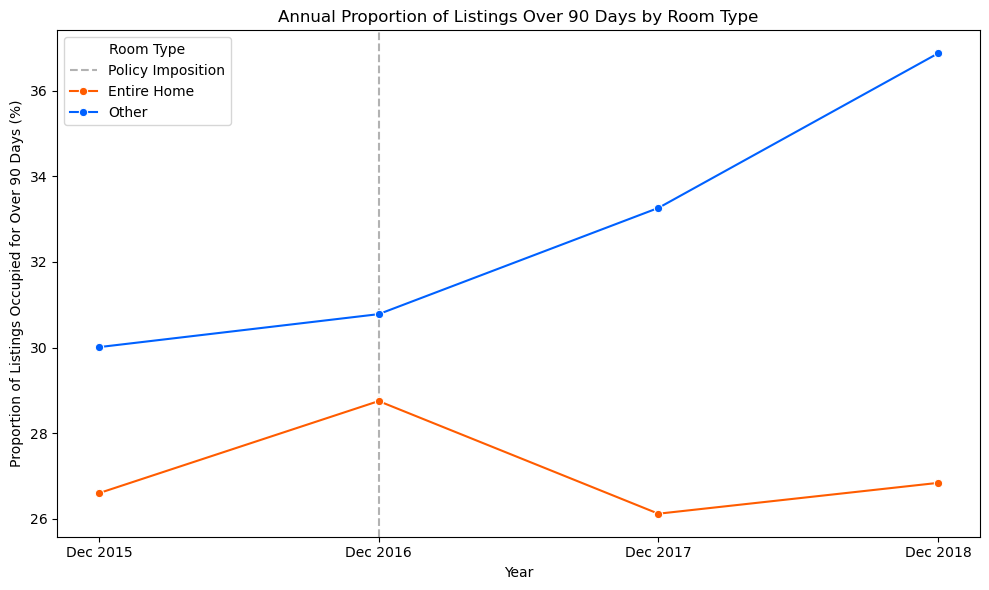

In [96]:
## Difference in Differences in Proportions

#First, reformat the data
#ChatGPT helped with the melt method
rooms_pivoted = room_proportions.melt(id_vars='room_type', 
                                  value_vars=['pct_90_2015', 'pct_90_2016', 'pct_90_2017', 'pct_90_2018'], 
                                  var_name='Year', 
                                  value_name='Proportion Over 90 Days')

#Format the year column
rooms_pivoted['Year'] = rooms_pivoted.Year.str[-4:].astype(int)

#Plot change in proportion over time

colours = {'Entire Home': '#ff5c00', 'Other': '#0061ff'}

#Figure
plt.figure(figsize=(10, 6))
plt.axvline(x=2016, color='grey', alpha=0.6, linestyle='--', label='Policy Imposition')
sns.lineplot(data=rooms_pivoted, x='Year', y='Proportion Over 90 Days', hue='room_type', marker='o', palette=colours)
#Labels
plt.title('Annual Proportion of Listings Over 90 Days by Room Type')
plt.xlabel('Year')
plt.ylabel('Proportion of Listings Occupied for Over 90 Days (%)')
plt.legend(title='Room Type')

#Sort out x-ticks: add Dec to make it clear it's for cumulative year
xticks = years
xticklabels = [f'Dec {year}' for year in xticks]
plt.xticks(xticks, xticklabels)

plt.tight_layout()
plt.show()